### Multiround UNL Attack 

Jan 18 2024
TJ Kim

##### Summary
Load FAT model trained for 150 rounds and for 50 rounds try and inject FedAvg model into the system. Try different scaling rates and spread out the model replacement attack.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [6]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 163.36it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:33<00:00,  2.39it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


In [7]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [8]:
# Find mag norm 
mag_norm_FAT2FedAvg = []
for key in desired_keys: #params_FAT:

    diff =  params_FAT[key] - params_FedAvg[key]
    l2_norm = torch.norm(diff, p=2)

    mag_norm_FAT2FedAvg += [diff/torch.norm(diff,p=2)]


In [9]:
# Calculate uploaded model and download to attacker clients in aggregator
# Current version working under the assumption of close to convergence (no benign client pushback)
def calc_atk_model(model_inject, model_global, keys, weight_scale, weight_scale_2):

    atk_model = copy.deepcopy(model_global)
    inject_state_dict = model_inject.state_dict(keep_vars=True)
    global_state_dict = model_global.state_dict(keep_vars=True)
    return_state_dict = atk_model.state_dict(keep_vars=True)
    total_weight = weight_scale * weight_scale_2

    for key in keys:
        diff = inject_state_dict[key].data.clone() - global_state_dict[key].data.clone()
        return_state_dict[key].data = total_weight * diff + global_state_dict[key].data.clone()

    return atk_model

# Clone data from attack model to client model
def clone_model_weights(model_source, model_target, keys):
    target_state_dict = model_target.state_dict(keep_vars=True)
    source_state_dict = model_source.state_dict(keep_vars=True)
    
    for key in keys:
        target_state_dict[key].data = source_state_dict[key].data.clone()

    return

# Expand aggregator.mix() function
def UNL_mix(aggregator, adv_id, model_inject, keys, weight_scale_2, dump_flag=False, aggregation_op = None, tm_beta = 0.05):
    weight_scale = 1/aggregator.clients_weights
    model_global = aggregator.global_learners_ensemble[0].model

    if aggregation_op == None:
        aggregation_op = aggregator.aggregation_op

    # Give adversarial clients boosted models and train regular clients 1 round
    benign_id = list(range(len(aggregator.clients)))
    for a_id in adv_id:
        benign_id.remove(a_id)
        temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)
        aggregator.clients[a_id].learners_ensemble[0].model = copy.deepcopy(temp_atk_model)

    for c_id in benign_id:
        aggregator.clients[c_id].step()

    # Aggregate model and download
    for learner_id, learner in enumerate(aggregator.global_learners_ensemble):
        learners = [client.learners_ensemble[learner_id] for client in aggregator.clients]
        if aggregation_op is None:
            average_learners(learners, learner, weights=aggregator.clients_weights)
        elif aggregation_op == 'median':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'trimmed_mean':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_tm.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_tm(
                learners, 
                learner, 
                beta=tm_beta, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum_modelwise':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum_modelwise.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum_modelwise(
                1,
                learners,
                learner,
                dump_path=dump_path
            )
        else:
            raise NotImplementedError


    # assign the updated model to all clients
    aggregator.update_clients()

    aggregator.c_round += 1

    # if aggregator.c_round % aggregator.log_freq == 0:
    #     aggregator.write_logs()
    return 

In [29]:
beta_params = [0.2]
num_aru = [10]
weight2_list = [0.15]
num_rounds = 30


result_list = []
for itt in range(len(beta_params)):
    result_list += [{}]

setting, num_user = "FedAvg_adv", 40
save_path_FedAvg_150R = 'weights/cifar10/231031_FAT150round/FAT'
aggregator, clients, args_ = set_args(setting, num_user)
aggregator.aggregation_op = 'trimmed_mean'

if True:
    print("updating adv data set")
    # add adv dataset update
    Fu = np.zeros(num_user)
    Fu[0:10] = 1

    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 10,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)

    # Assign proportion and attack params
    for c in range(len(clients)):
        if Fu[c] > 0:
            aggregator.clients[c].set_adv_params(Fu[c], atk_params)
            aggregator.clients[c].update_advnn()
            aggregator.clients[c].assign_advdataset()

for itt in range(len(beta_params)):
    # Perform 50 rounds of FAT on FedAvg model 
    num_adv = num_aru[itt]
    weight2 = 1/num_adv * weight2_list[itt]
    adv_id = random.sample(range(10,num_user), num_adv) # excluding 0-9 as Fu = 1
    beta = beta_params[itt]

    test_acc_gather = []
    adv_acc_gather = []
    test_acc_std = []
    adv_acc_std = []
    cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

    aggregator.tm_rate = beta

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FedAvg_150R)
    aggregator.update_clients()
    model_FA = pull_model_from_agg(aggregator)
    model_FA.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_FA)

    prev_model = copy.deepcopy(model_FA)

    print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    test_acc_std += [np.std(acc)]
    adv_acc_std += [np.std(adv_acc)]



    for i in range(num_rounds):

        # Per round Freq

        # aggregator.mix()
        UNL_mix(aggregator, adv_id, model_inject = model_Fedavg, keys = desired_keys, weight_scale_2 = weight2, dump_flag=False, tm_beta=beta)
        model_overfit = pull_model_from_agg(aggregator)
        model_overfit.eval()
        acc, adv_acc = get_adv_acc(aggregator, model_overfit)

        print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
        test_acc_gather+= [np.mean(acc)]
        adv_acc_gather += [np.mean(adv_acc)]
        test_acc_std += [np.std(acc)]
        adv_acc_std += [np.std(adv_acc)]
        prev_model = copy.deepcopy(model_overfit)

        result_list[itt]['test_acc'] = copy.deepcopy(test_acc_gather)
        result_list[itt]['adv_acc'] = copy.deepcopy(adv_acc_gather)
        result_list[itt]['test_std'] = copy.deepcopy(test_acc_std)
        result_list[itt]['adv_std'] = copy.deepcopy(adv_acc_std)
        result_list[itt]['num_clients'] = num_adv
        result_list[itt]['beta'] = beta
        result_list[itt]['weight2'] = weight2_list[itt]
        # Perform gradient direction gathering

    

==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 206.71it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:30<00:00,  2.60it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


updating adv data set
Test acc:  0.8025000169873238 adv acc:  0.3543750051409006
round 0 Test acc:  0.8115625083446503 adv acc:  0.3246875055134296
round 1 Test acc:  0.8121875137090683 adv acc:  0.2956250041723251
round 2 Test acc:  0.815625011920929 adv acc:  0.26906250417232513
round 3 Test acc:  0.8093750149011611 adv acc:  0.2334375036880374
round 4 Test acc:  0.7978125095367432 adv acc:  0.21031250506639482
round 5 Test acc:  0.8181250125169754 adv acc:  0.20343750566244126
round 6 Test acc:  0.8206250101327897 adv acc:  0.19000000450760127
round 7 Test acc:  0.8193750083446503 adv acc:  0.18875000327825547
round 8 Test acc:  0.8250000104308128 adv acc:  0.18750000298023223
round 9 Test acc:  0.8237500175833702 adv acc:  0.18000000212341546
round 10 Test acc:  0.8284375116229057 adv acc:  0.16250000353902577
round 11 Test acc:  0.8290625095367432 adv acc:  0.16156250303611158
round 12 Test acc:  0.8284375071525574 adv acc:  0.1678125025704503
round 13 Test acc:  0.833125011622905

In [38]:
import pickle

a = result_list

with open('saved_results/tmsweep/240130_05.pk', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# load relevant information and plot 
plot_settings = [[5, 0.05, 0.3],[5, 0.1, 0.2],[5, 0.2, 0.1],[10, 0.2, 0.15]] # [num_aru, tm_param, scale]

adv_acc_plotter = []
adv_std_plotter = []

# LINE NO 1
with open('saved_results/tmsweep/240130_04.pk', 'rb') as handle:
    loaded = pickle.load(handle)
adv_acc_plotter += [loaded[0]["adv_acc"]]
adv_std_plotter += [loaded[0]["adv_std"]]

# line no 2
with open('saved_results/tmsweep/240130_03.pk', 'rb') as handle:
    loaded = pickle.load(handle)
adv_acc_plotter += [loaded[0]["adv_acc"]]
adv_std_plotter += [loaded[0]["adv_std"]]
# line no 3 
adv_acc_plotter += [loaded[1]["adv_acc"]]
adv_std_plotter += [loaded[1]["adv_std"]]

# line no 4
with open('saved_results/tmsweep/240130_05.pk', 'rb') as handle:
    loaded = pickle.load(handle)
adv_acc_plotter += [loaded[0]["adv_acc"]]
adv_std_plotter += [loaded[0]["adv_std"]]

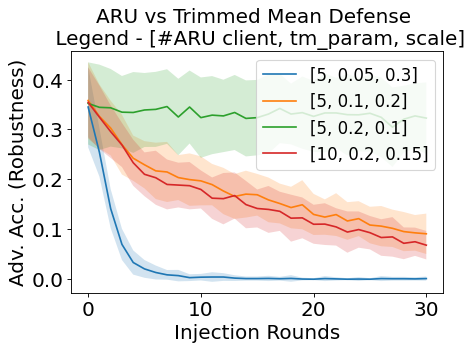

In [5]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

# Generate some sample data
x = range(len(adv_acc_plotter[0]))  # 100 points from 0 to 10

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
label_list = plot_settings
for i in range(len(label_list)):
    y = np.array(adv_acc_plotter[i])
    error = np.array(adv_std_plotter[i])
    plt.plot(x, y, label= str(label_list[i]))
    plt.fill_between(x, y-error, y+error,
    alpha=0.2)

# Adding labels and title
plt.xlabel('Injection Rounds')
plt.ylabel('Adv. Acc. (Robustness)')
plt.title('ARU vs Trimmed Mean Defense \n Legend - [#ARU client, tm_param, scale]', fontsize = 'medium')

# Adding a legend
plt.legend( loc=1, fontsize='small')

# Display the plot
plt.show()
